_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens, Dr. Alexander Ecker

Tutors: Sarah Strauss, Santiago Cadena

Summer term 2019

Due date: 2019-04-23, 9am

Student names: Ulzii-Utas, Guillem Boada

# Exercise sheet 1

Download the data file ```nda_ex1.csv``` from ILIAS and save it in a subfolder ```../data/```.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.decomposition import PCA
import scipy as sp
import itertools as it
import time
sns.set_style('whitegrid')
%matplotlib inline

## Load data

In [2]:
Fs = 30000     # sampling rate of the signal in Hz
dt = 1/Fs
gain = .5      # gain of the signal
x = pd.read_csv('../data/nda_ex_1.csv', header=0, names=('Ch1', 'Ch2', 'Ch3', 'Ch4'))

In [3]:
x.head()

Ch1  Ch2  Ch3  Ch4
0 -141 -184 -316 -191
1 -136 -167 -290 -196
2 -168 -185 -306 -219
3 -147 -188 -332 -219
4 -165 -196 -331 -206

## Task 1: Filter Signal

In order to detect action potentials, the first step is to filter out low frequency fluctuations (LFP) and high frequency noise. Determine appropriate filter settings and implement the filtering in the function ```filterSignal()```. A typical choice for this task would be a butterworth filter. Plot a segment of the raw signal and the filtered signal for all four channels with matching y-axis. The segment you choose should contain spikes. When you apply the function also test different filter settings.

*Grading: 2 pts*


In [4]:
def filterSignal(x, Fs, low, high, order=5):
# Filter raw signal
#   y = filterSignal(x, Fs, low, high) filters the signal x. Each column in x is one
#   recording channel. Fs is the sampling frequency. low and high specify the passband in Hz.
#   The filter delay is compensated in the output y.

    # Generate filter
    nyq = Fs/2 # Nyquist freq used to normalize input cutoff freqs
    b, a = signal.butter(order, [low/nyq, high/nyq], btype='band')
    
    # Create an independent output dataframe with the same shape as x
    y = x.copy(deep=True)
    
    # Apply filter
    for row, col in enumerate(x):
        y[col] = signal.filtfilt(b, a, x[col])
        
    return y

In [5]:
xf = filterSignal(x, Fs, 500, 4000, order=5)
xf.head()

Ch1       Ch2       Ch3        Ch4
0  -3.225894 -5.660913 -2.092908  -5.709709
1  -4.382755 -3.202977  4.022874  -8.699247
2  -9.013680 -1.902255  6.368220 -12.150411
3 -18.875937 -2.854287  2.734572 -16.866847
4 -33.022144 -6.674506 -6.564842 -23.568985

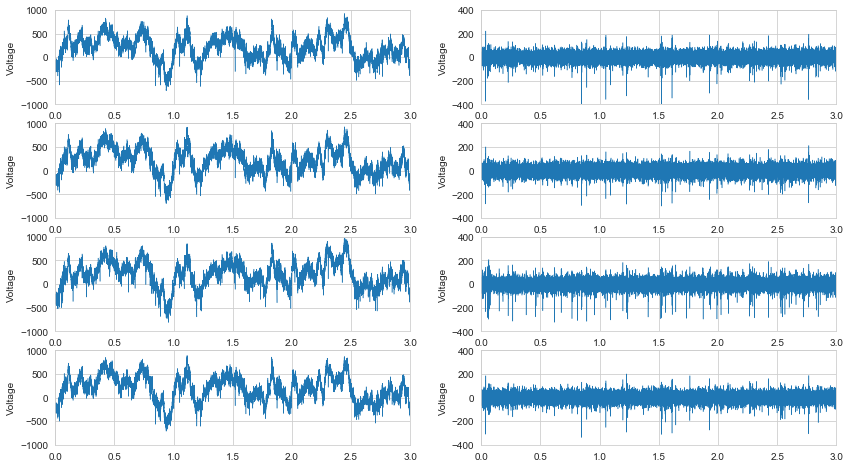

In [6]:
plt.figure(figsize=(14, 8))

N = 100000 # segment to sample
t = np.arange(0,N) * dt # time vector

for i, col in enumerate(x):
    # Raw signal, x
    plt.subplot(4,2,2*i+1)
    plt.plot(t,x[col][0:N],linewidth=.5)
    plt.ylim((-1000, 1000))
    plt.xlim((0,3))
    plt.ylabel('Voltage')
    
    # Filtered signal, xf
    plt.subplot(4,2,2*i+2)
    plt.plot(t,xf[col][0:N],linewidth=.5)
    plt.ylim((-400, 400))
    plt.xlim((0,3))
    plt.ylabel('Voltage')
    

## Task 2: Detect action potentials

Action potentials are usually detected by finding large-amplitude deflections in the continuous signal. A good choice of threshold for detecting spikes is important. If it is too low, you will detect too many low amplitude events (noise); if it is too high, you run the risk of missing good spikes. Implement an automatic procedure to obtain a reasonable threshold and detect the times when spikes occurred in the function ```detectSpikes()``` . Plot a segment of the filtered signal for all four channels with matching y-axis and indicate the time points where you detected spikes. Plot the threshold. Are the detected time points well aligned with peaks in the signal?

We are tasked to detect the action potentials. However, as shown in previous task, it is challenging to find the the right amount of threshold which indicates the spike. We can see in the below picture:  If we take <span style="color:red">Low threshold</span>, we would be considering almost everything. Opposite goes for <span style="color:blue">High threshold</span> where we would be discarding the most of the spikes. Therefore, there are number of methods such as: <span style="font-style:italic;">Absolute value, Teager energy operator and Higher-order    differential    energy    operator [2]</span>.

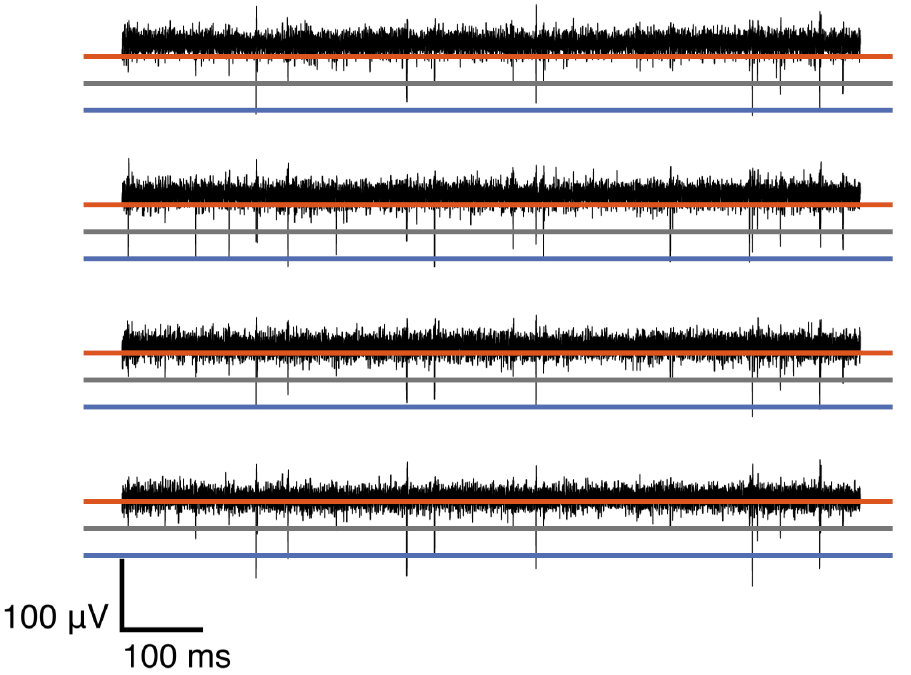

### Absolute Value

By using the absolute value of the signal, we can detect a spike using the following equation:

$Threshold = M \sigma$, $\sigma = median {\frac{|x_n|}{0.6745}}$

 where $M$ is the threshold multiplier, $\sigma$ is the estimate of noise standard deviation and $x_n$ is signal at time n.

### Teager energy operator

TEO [3] is given by:

 $\phi(x_n) = x^2_n - x_{n+1}x_{n-1}$

but Time-domain averaging cannot be used in TEO but frequency-domain windowing can be used.

$\phi_s(x_n) = \phi_s(x_n)  \otimes w_n$

where $\otimes$ is convolution, $w_n$ is Hamming window[4] 

$Threshold = M \frac{1}{N}\sum_{n=1}^N\phi_s(x_n)$

### Higher-order    differential    energy    operator

An adaptive threshold of High order differential energy operator is:

$Threshold = argmax_{T} [H_s(T) + H_N(T)]$ where

$H_s(T) = - \sum_{g=0}^T \frac{p(g)}{P(T)}\log{\frac{p(g)}{P(T)}}$

$H_N(T) = - \sum_{g=T+1}^G \frac{p(g)}{P(T)}\log{\frac{p(g)}{P(T)}}$

$T$ is the cutoff value that maximizes the entropy between spike $H_s$ and noise $H_N$ distributions.

There were other methods for detecting spikes but in this task we used <span style = 'font-style:italic;'>Absolute value</span> method for simplicity. Also, the detected spike at $Channel_i$ is considered to be a spike in other channels $Channel_{j \neq i}$

In [7]:
def detectSpikes(x,Fs):
# Detect spikes
# s, t = detectSpikes(x,Fs) detects spikes in x, where Fs the sampling
#   rate (in Hz). The outputs s and t are column vectors of spike times in
#   samples and ms, respectively. By convention the time of the zeroth
#   sample is 0 ms.

    # Initialize variables
    s_all, t = [[] for i in range(4)], [[] for i in range(4)]
    thr = np.zeros(4)
    window = 300 # opened window after finding sample>thr, in samples
    
    # For the 4 channels
    for idx, col in enumerate(x): # idx -> # channel     col -> [Ch1,Ch2,Ch3,Ch4]
        # Set threshold
        thr[idx] = 5*np.median(np.abs(x[col])/0.6745) # multiple *5 of the cool formula for improved SD estimation
        
        i=0
        while (i<len(x[col])):
            if x[col][i]<-thr[idx]: # np.abs() because to detect the spike in both + and - configuration
                s_all[idx].append(np.argmin(x[col][i:i+window])) # Take the maximum of the window in front as the spike location
                i+=window
            else:
                i+=1
                
    # get the unique values of the array in ascending order
    s = np.unique(np.concatenate((np.array(s_all[0]),np.array(s_all[1]),np.array(s_all[2]),np.array(s_all[3]))))

    # delete those which are not identical but very close (it happens that the same spike is detected in different channels with some samples of difference)
    to_delete = []
    for i in range(len(s)-1): 
        if (s[i]+10)>(s[i+1]):
            to_delete.append(i)
    s = np.delete(s, to_delete)

    # in ms
    t = (s-s[0])*dt*1000
        
    return (s, t, thr)

In [8]:
start = time.time()

s, t, thr = detectSpikes(xf,Fs)

end = time.time()
print(end - start)

C:\ProgramData\Anaconda3\envs\ss19coding\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


1949.2729892730713


In [20]:
print(len(s))

15977


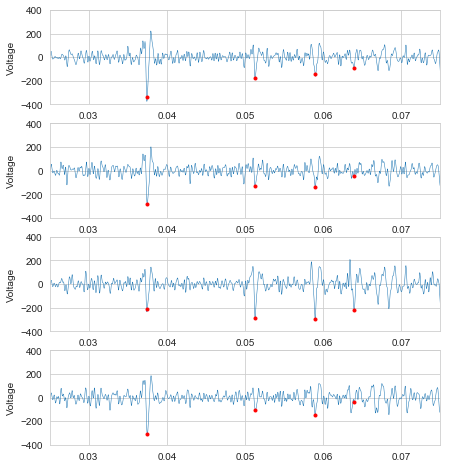

In [19]:
for i,val in enumerate(s):
    if val>N:
        s_stop = i-1
        break
s_short = s[0:s_stop]

plt.figure(figsize=(7, 8))

tt = np.arange(0,N) * dt 

for i, col in enumerate(xf[0:N]):
    plt.subplot(4,1,i+1)
    plt.plot(tt,xf[col][0:N],linewidth=.5)
    plt.plot(s_short*dt,xf[col][s_short],'r.')
    plt.ylim((-400, 400))
    plt.xlim((0.025,0.075))
    plt.ylabel('Voltage')

Comment: The spikes are not completely aligned in the 4 channels

## Task 3: Extract waveforms
For later spike sorting we need the waveforms of all detected spikes. Extract the waveforms segments (1 ms) on all four channels for each spike time (as a result each spike is represented by a 4x30 element matrix). Implement this procedure in the function ```extractWaveforms()```. Plot (a) the first 100 spikes you detected and (b) the 100 largest spikes you detected. Are there a lot of very small spikes (likely noise) among your detected spikes? If so your threshold may be too low. Can you see obvious artifacts, not looking like spikes at all?

In this task, we extracted the waveforms from the detected spikes. To do this, we open a window to both sides of the spike and get the amplitude at each time (total 30 times). The result for extraction is shown in the figure below.

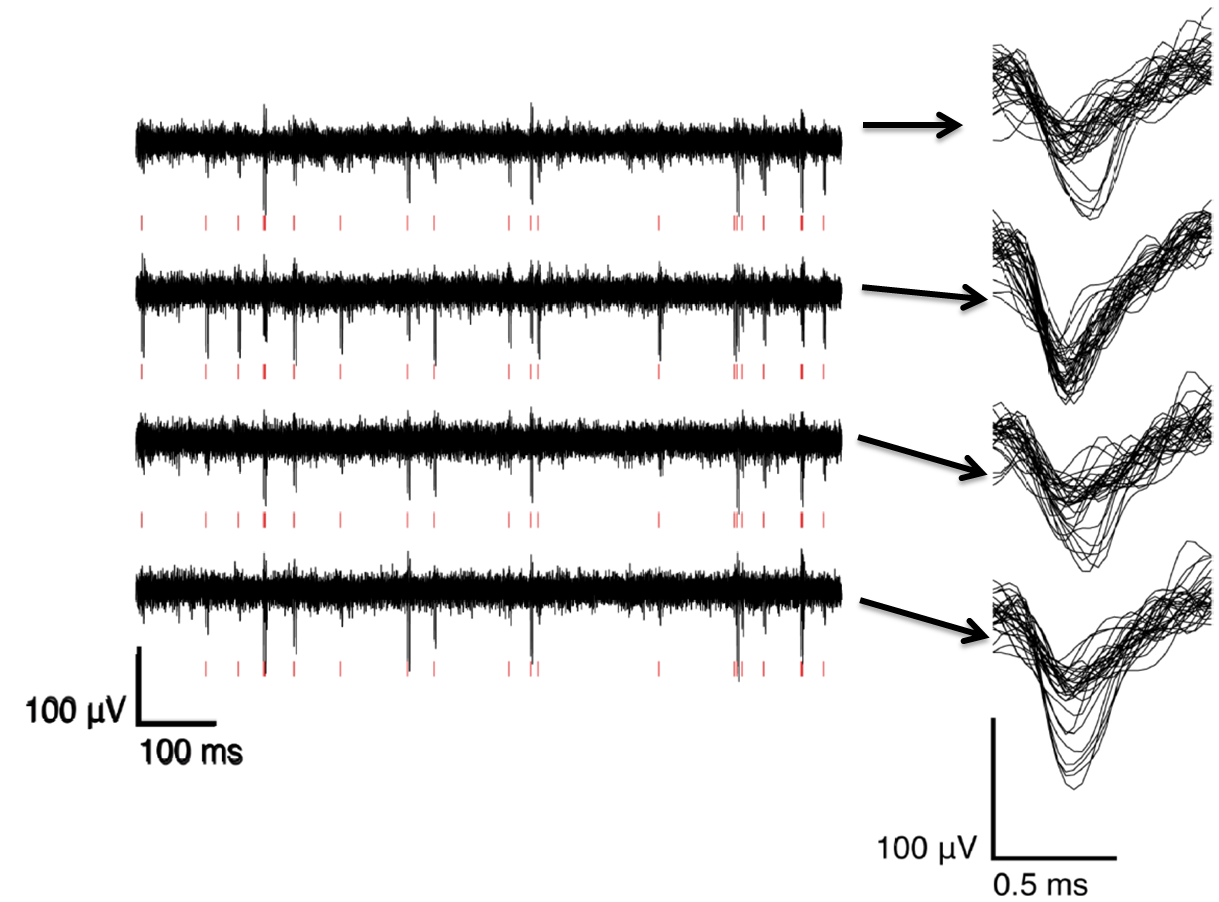

In [21]:
def extractWaveforms(x, s):
# Extract spike waveforms.
#   w = extractWaveforms(x, s) extracts the waveforms at times s (given in
#   samples) from the filtered signal x using a fixed window around the
#   times of the spikes. The return value w is a 3d array of size
#   length(window) x #spikes x #channels.

    window = 30 #samples
    w = np.zeros((window, len(s), 4))
    for col in range(4):
        for i in range(len(s)):
            w_start = int(s[i]-window/2)
            w_end = int(s[i]+window/2)
            w[:,i,col] = x[w_start:w_end,col]

    return w

In [22]:
start = time.time()

w = extractWaveforms(xf.values, s)

end = time.time()
print(end - start)

3.692607879638672


Plot first 100 spike waveforms

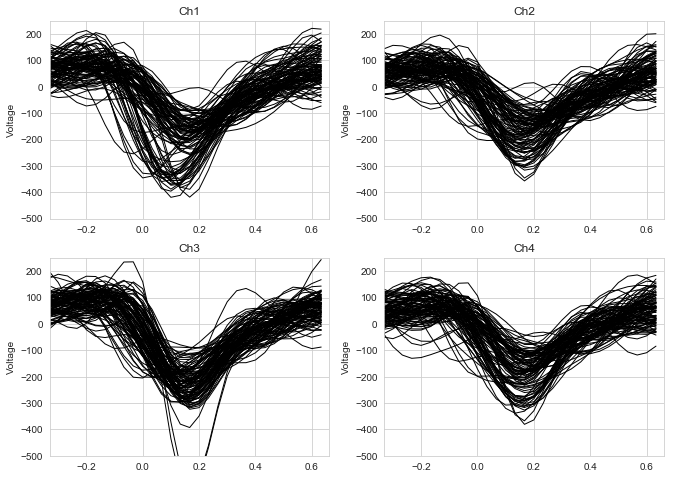

In [23]:
t = np.arange(-10,20) * dt * 1000 

plt.figure(figsize=(11, 8))

for i, col in enumerate(xf):
    plt.subplot(2,2,i+1)
    plt.plot(t,w[:,0:100,i],'k', linewidth=1)
    plt.ylim((-500, 250))
    plt.xlim((-0.33,0.66))
    plt.ylabel('Voltage')
    plt.title(col)

Plot largest 100 spike waveforms

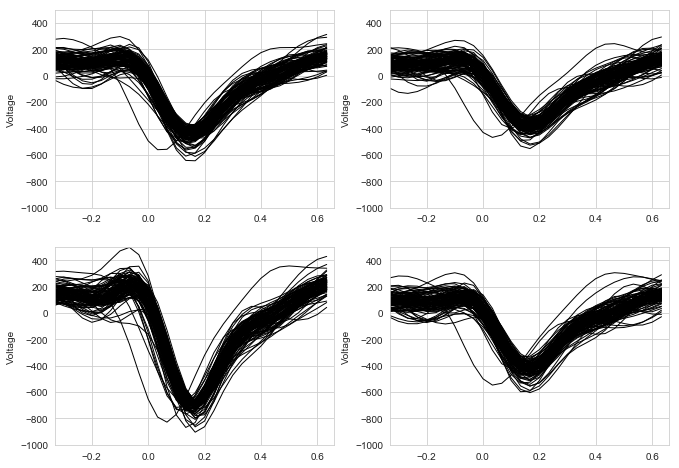

In [24]:
idx = np.argsort(np.min(np.min(w,axis=2),axis=0))

t = np.arange(-10,20) * dt * 1000 

plt.figure(figsize=(11, 8))
for i, col in enumerate(xf):
    plt.subplot(2,2,i+1)
    plt.plot(t,w[:,idx[0:100],i],'k', linewidth=1)
    plt.ylim((-1000, 500))
    plt.xlim((-0.33,0.66))
    plt.ylabel('Voltage')


  Even though we detected a spike from on $Channel_i$, we could have no spikes in other $Channel_{j\neq i}$. So that we could very noisy waveforms. However, by ploting the largest 100 spikes, we could show the spikes that only the $Channel_i$ detected.

## Task 4: Extract features using PCA
Compute the first three PCA features on each channel separately in ```extractFeatures()```. You can use a available PCA implementation or implement it yourself. After that, each spike is represented by a 12 element vector. Compute the fraction of variance captured by these three PCs.
Plot scatter plots for all pairwise combinations of 1st PCs. Do you see clusters visually? 

From the waveform extraction, we have 30 features of one spike for each channel. However, this becomes too many dimensions and we want the features which best expresses the characteristics of the spikes. The task is to find the first three PCA features and plot the 1st PCs of each channel.

After getting the first three PCA, we can use the variance for each PCs to choose the best PCs for our spikes along the channels

The image below shows basic idea about how PCA works. PCA finds The best line according to different features which is the line with the highest variance. 

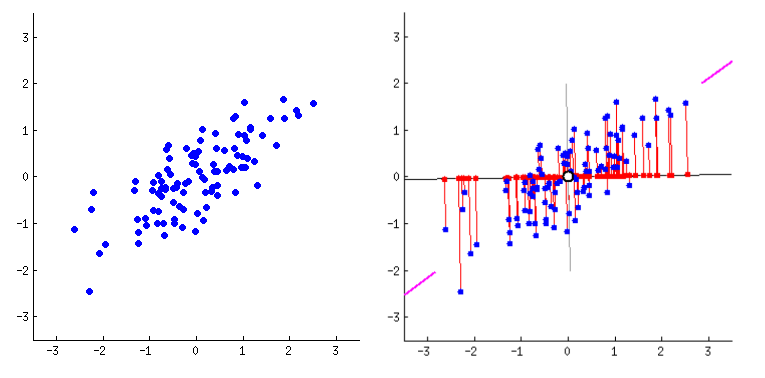

For independent features, we can use PCA to find the which combinations of these variables matter the most. Since we are trying to find the PC with the highest variance, our clustering for different channels will have more seperation.

In [25]:
def extractFeatures(w):
# Extract features for spike sorting.
#   b = extractFeatures(w) extracts features for spike sorting from the
#   waveforms in w, which is a 3d array of size length(window) x #spikes x
#   #channels. The output b is a matrix of size #spikes x #features.
#   The implementation should do PCA on the waveforms of each channel
#   separately and uses the first three principal components. Thus, we get
#   a total of 12 features. Also, the varianced explained by the 3 features per channel
#   should be computed.
    
    N_spikes = w.shape[1]
    b_3d = np.zeros((3,N_spikes,4))
    
    for ch in range(4):
        # prepare input for the PCA
        X = w[:,:,ch]
        X_t = np.transpose(X)

        # Initialize PCA
        pca = PCA(n_components=3) # what is this n_components? # of PCs that i want to get
        # Apply PCA to our data
        pca.fit(X_t)
        # PCA transformation
        b_3d[:,:,ch] = np.transpose(pca.transform(X_t)) # what is this exactly doing?
        
        b = np.zeros((N_spikes, 12))
        for i in range(len(s)):
            b[i,:] = np.concatenate((b_3d[:,i,0], b_3d[:,i,1], b_3d[:,i,2], b_3d[:,i,3]))
            
        
        # Calculate explained variances in %
        total_variance = np.sum(pca.explained_variance_)
        var_PC1 = pca.explained_variance_[0]/total_variance
        var_PC2 = pca.explained_variance_[1]/total_variance
        var_PC3 = pca.explained_variance_[2]/total_variance
        
        variances = np.round([var_PC1, var_PC2, var_PC3],3)
        print('\nCH{} Explained variances:\nPC1:{}\nPC2:{}\nPC3:{}'.format(ch+1,variances[0],variances[1],variances[2]))

    return b, variances


In [26]:
b, variances = extractFeatures(w)


CH1 Explained variances:
PC1:0.633
PC2:0.274
PC3:0.093

CH2 Explained variances:
PC1:0.561
PC2:0.296
PC3:0.144

CH3 Explained variances:
PC1:0.583
PC2:0.291
PC3:0.126

CH4 Explained variances:
PC1:0.562
PC2:0.289
PC3:0.149


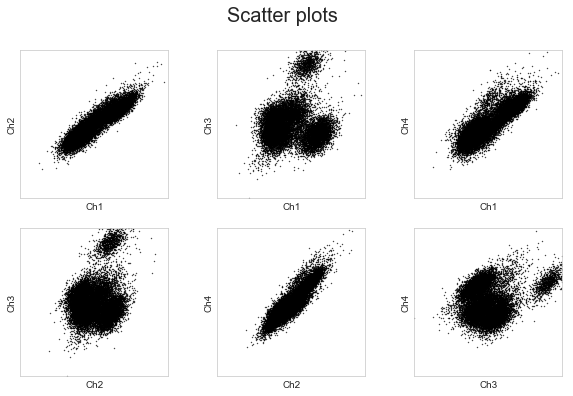

In [27]:
plt.figure(figsize=(10, 6))
plt.suptitle('Scatter plots',fontsize=20)

idx = [0, 3, 6, 9]
p = 1
labels = ['Ch1','Ch2','Ch3','Ch4']
for i in np.arange(0,4):
    for j in np.arange(i+1,4):
        ax = plt.subplot(2,3,p, aspect='equal')
        plt.plot(b[:,idx[i]],b[:,idx[j]],'.k', markersize=.7) 
        plt.xlabel(labels[i])
        plt.ylabel(labels[j])
        plt.xlim((-1000,1000))
        plt.ylim((-1000,1000))
        ax.set_xticks([])
        ax.set_yticks([])
        p = p+1

In [30]:
np.save('../data/nda_ex_1_features_3',b)
np.save('../data/nda_ex_1_spiketimes_3',s)
np.save('../data/nda_ex_1_waveforms_3',w)

[1] Quian Quiroga R, Nadasdy Z, Ben-Shaul Y (2004) Unsupervised Spike Detection and Sorting with Wavelets and Superparamagnetic Clustering. Neural Comp 16:1661-1687. 

[2] A. K. Ng, K. K. Ang, C. Guan, "Automatic selection of neuronal spike detection threshold via smoothed Teager energy histogram", Proc. 6th Int. IEEE/EMBS Conf. Neural Eng. (NER), pp. 1437-1440, Nov. 2013.

[3] S. Mukhopadhyay and G.C. Ray, “A new interpretation of nonlinear energy  operator  and  its  efficacy  in  spike  detection,” IEEE  Trans. Biomed. Eng., vol. 45, pp. 180–187, 1998.

[4] H.  Semmaoui,  J.  Drolet,  A.  Lakhssassi,  and  M.  Sawan,  “Setting adaptive spike detection threshold for smoothed TEO based on robust statistics theory,” IEEE  Trans.  Biomed.  Eng.,  vol.  59,  pp.  474–482, 2012. 
